# Self-Driving Car Engineer Nanodegree

## Deep Learning

Going to test my traffic sign classifier with the CIFAR 10 dataset. 

---
# Admin

Load packages

In [1]:
# standard packages
import os
import random
import numpy as np
import pandas as pd

# image manipulation packages
import cv2

# tensorflow packages
import tensorflow as tf

In [2]:
from tensorflow.contrib.layers import flatten

In [3]:
from sklearn.utils import shuffle

Set some notebook parameters

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 6.0)

# Load data

In [37]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# y_train.shape is 2d, (50000, 1). While Keras is smart enough to handle this
# it's a good idea to flatten the array.

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify = y_train)


---
# EDA

Results of basic exploratory data analysis.  

In [39]:
print(len(X_train))
print(len(X_valid))
print(len(X_test))

35000
15000
10000


In [40]:
X_train[1].shape

(32, 32, 3)

Imbalanced classes

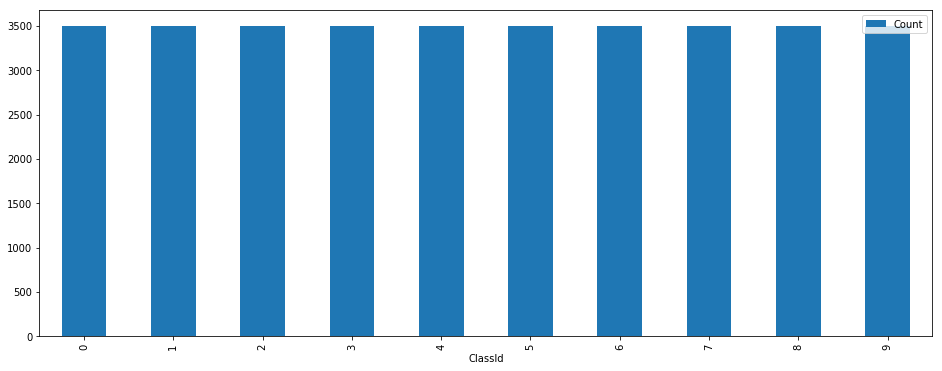

In [41]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)

df = pd.DataFrame({'ClassId':unique_elements, 
                   'Count':counts_elements
                  })

df = df.sort_values('Count')

df.plot('ClassId', 'Count', kind='bar')

Sample class images

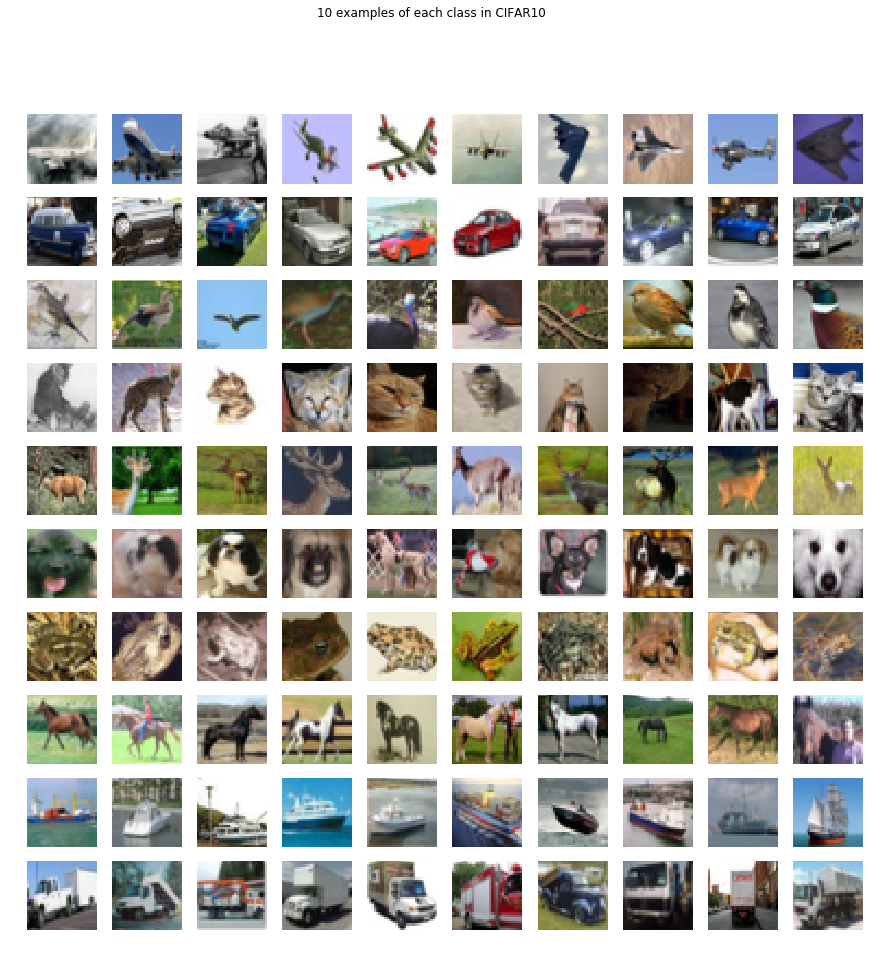

In [46]:
nclasses  = 10 # number of classes to visualize
nexamples = 10 # number of examples for each class

# Chosing indices from training set images
training_labels = np.array(y_train)
img_idx = [np.where(training_labels==class_id)[0][0:nexamples] for class_id in range(nclasses)]
        
# Creating plot with subplots
fig, axarr = plt.subplots(nclasses, nexamples, figsize=(15,15))

for class_id in range(nclasses):
    for i in range(nexamples):
        axarr[class_id,i].imshow(X_train[img_idx[class_id][i]])
        axarr[class_id,i].axis('off')

fig.suptitle('{} examples of each class in CIFAR10'.format(nexamples))

plt.show()

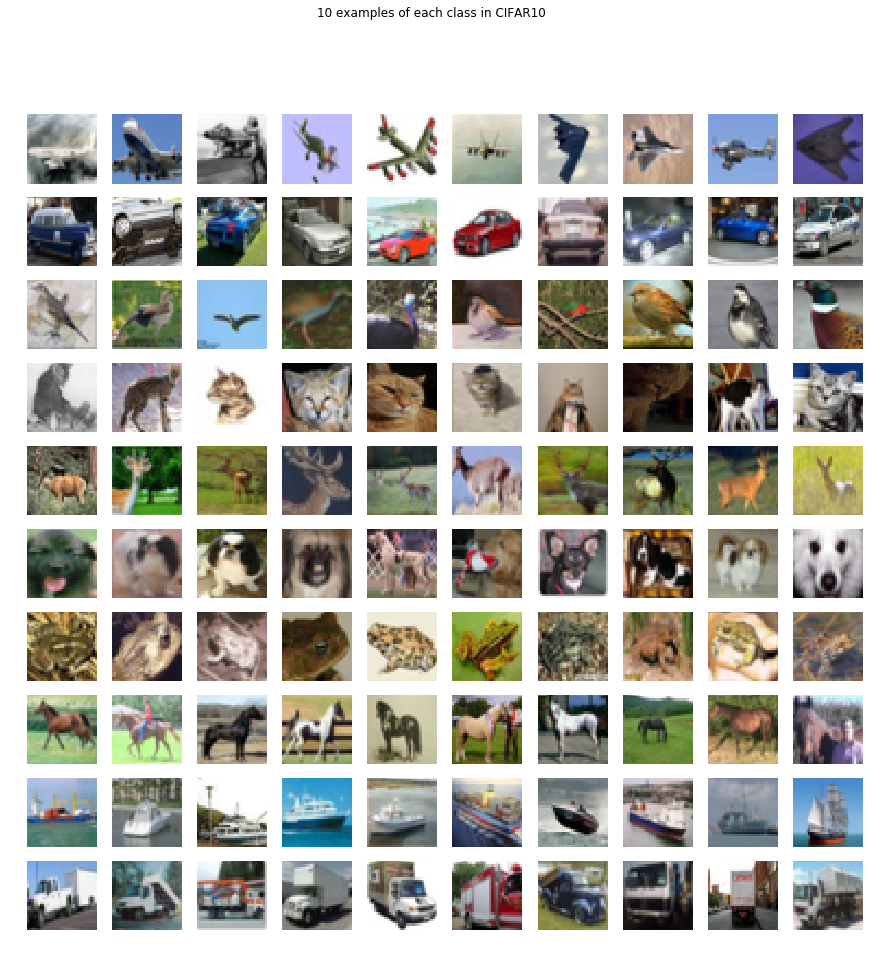

In [48]:
# define params
nclasses  = 10 # number of classes to visualize
nexamples = 10 # number of examples for each class

# Chosing indices from training set images
training_labels = np.array(y_train)
img_idx = [np.where(training_labels==class_id)[0][0:nexamples] for class_id in range(nclasses)]
        
# Creating plot with subplots
fig, axarr = plt.subplots(nclasses, nexamples, figsize=(15,15))

for class_id in range(nclasses):
    for i in range(nexamples):
        axarr[class_id,i].imshow(X_train[img_idx[class_id][i]])
        axarr[class_id,i].axis('off')
        
fig.suptitle('{} examples of each class in CIFAR10'.format(nexamples))

plt.show()

Fairly challenging images.  
Lighting conditions differ.  
Images of some signs are captured at slight angles.  
On the other hand, the signs tend to centred in the images. This is not what we might expect in real life. We can mess around with this though during preprocessing.  

----
# Model

We'll try using fewer layers after convolving. 3 conv layers and 1 FC layers.  
We'll also try augmenting our dataset.  

## Step 1: Prep Data

In [138]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.OneOf([
        iaa.Crop(px=(0, 3)), # crop images from each side by 0 to 3px (randomly chosen)
        # it doesn't make sense to flip some of the signs
        #iaa.Fliplr(0.5), # horizontally flip 50% of the images
        iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 3.0
        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
        iaa.PerspectiveTransform(scale=(0.1, 0.2)) 
    ])
])

X_train_aug = seq.augment_images(X_train)

In [139]:
def rgb2y(array):
    
    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        img_yuv = cv2.cvtColor(np.array(array[i], dtype=np.uint8), cv2.COLOR_BGR2YUV, 1)
        y, u, v = cv2.split(img_yuv)
        
        y_reshaped = np.reshape(y, y.shape + (1,))

        array_y[i] = y_reshaped
        
    return array_y

In [140]:
def global_contrast_normalization(array, s=1, lmda=10, epsilon=0.000000001):    
    
    # https://datascience.stackexchange.com/questions/15110/how-to-implement-global-contrast-normalization-in-python

    array_y = np.empty((len(array), 32, 32, 1))
    
    for i in range(len(array)):
    
        X_average = np.mean(array[i])
    
        X = array[i] - X_average

        contrast = np.sqrt(lmda + np.mean(X**2))

        X = s * X / max(contrast, epsilon)

        array_y[i] = X
        
    return array_y

In [141]:
X_train.shape

(35000, 32, 32, 3)

In [142]:
print('old mean: %s' %np.mean(X_train))
print('old std:  %s' %np.std(X_train))

old mean: 120.775791044
old std:  64.1213577031


In [143]:
def random_image(array, index=None): 
    
    if index==None: 
        
        max_index = len(array)
        index = np.random.randint(low=0,high=max_index)
    
    img = array[index].squeeze()
    
    plt.imshow(img)

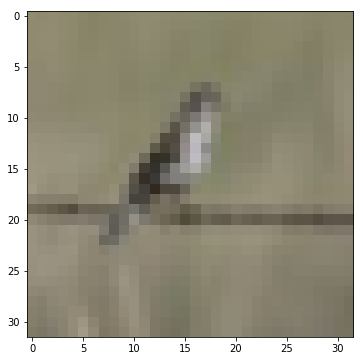

In [144]:
random_image(array=X_train, index=1000)

In [145]:
def preprocess(x): 
    
    x = rgb2y(x)
    x = global_contrast_normalization(x)
    
    return x

In [146]:
X_train_processed = preprocess(np.concatenate((X_train, X_train_aug), axis=0))
y_train_processed = np.concatenate((y_train, y_train), axis=0)


X_valid_processed = preprocess(X_valid)
X_test_processed  = preprocess(X_test)

In [147]:
X_train_processed.shape

(70000, 32, 32, 1)

In [148]:
y_train_processed.shape

(70000,)

In [149]:
print('new mean: %s' %np.mean(X_train_processed))
print('new std:  %s' %np.std(X_train_processed))

new mean: 4.08217606543e-20
new std:  0.996877424152


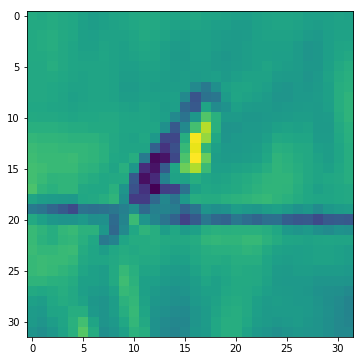

In [150]:
random_image(array=X_train_processed, index=1000)

In [151]:
X_train_processed, y_train_processed = shuffle(X_train_processed, y_train_processed)

## Step 2: Design and Test a Model Architecture

define training pipeline/architecture. 

In [152]:
from collections import namedtuple

Parameters = namedtuple(
    'Parameters', 
    [
        # Data parameters
        'num_classes', 
        'image_size', 
        
        # Layers architecture
        'conv1_k', 
        'conv1_d', 
        
        'conv2_k', 
        'conv2_d', 
        
        'conv3_k', 
        'conv3_d', 
        
        'fc1_size', 
    ])

In [153]:
parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),

    # Layers architecture
    conv1_k = 5, 
    conv1_d = 32,
    
    conv2_k = 5, 
    conv2_d = 64, 
    
    conv3_k = 5, 
    conv3_d = 128, 
    
    fc1_size = 1000, 
)

In [154]:
def cnn(x, params):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    conv1_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.conv1_k, params.conv1_k, 1, params.conv1_d), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    conv1_b = tf.Variable(
        tf.zeros(params.conv1_d)
    )
    
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b

    # SOLUTION: Activation.
    act1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x32. Output = 14x14x32.
    pool1 = tf.nn.max_pool(act1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # SOLUTION: Dropout
    pool1 = tf.nn.dropout(pool1, pkeep)

    
    
    # SOLUTION: Layer 2: Convolutional. Input = 14x14x32. Output = 10x10x64.
    conv2_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.conv2_k, params.conv2_k, params.conv1_d, params.conv2_d), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    conv2_b = tf.Variable(
        tf.zeros(params.conv2_d)
    )
    
    conv2 = tf.nn.conv2d(pool1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    # SOLUTION: Activation.
    act2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64.
    pool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # SOLUTION: Dropout
    pool2 = tf.nn.dropout(pool2, pkeep)
    
    
    
    # SOLUTION: Layer 3: Convolutional. Input = 5x5x64. Output = 1x1x128.
    conv3_W = tf.Variable(
        tf.truncated_normal(
            shape=(params.conv3_k, params.conv3_k, params.conv2_d, params.conv3_d), 
            mean = mu, 
            stddev = sigma
        )
    )
    conv3_b = tf.Variable(
        tf.zeros(params.conv3_d)
    )
    conv3 = tf.nn.conv2d(pool2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    
    # SOLUTION: Activation.
    act3 = tf.nn.relu(conv3)

    # SOLUTION: Pooling. Input = 1x1x128. Output = ??x??x128.
    pool3 = tf.nn.max_pool(act3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # SOLUTION: Dropout
    pool3 = tf.nn.dropout(pool3, pkeep)

    
    
    # SOLUTION: Flatten.     
    # 1st stage output 14x14x32
    pool1 = tf.nn.max_pool(pool1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    shape = pool1.get_shape().as_list()
    pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    
    # 2nd stage output 5x5x64    
    pool2 = tf.nn.max_pool(pool2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    shape = pool2.get_shape().as_list()
    pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])
    
    # 3rd stage output 1x1x128
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    # flatten
    fc0  = tf.concat(axis=1, values=[pool1, pool2, pool3])
    
    
    
    # SOLUTION: Layer 3: Fully Connected. Input = 1888. Output = 1000.
    fc1_W = tf.Variable(
        tf.truncated_normal(
            shape=(2816, params.fc1_size), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    fc1_b = tf.Variable(
        tf.zeros(params.fc1_size)
    )
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # SOLUTION: Dropout
    fc1 = tf.nn.dropout(fc1, pkeep)
    
      

    # SOLUTION: Layer 5: Fully Connected. Input = 1000. Output = 43.
    fc2_W  = tf.Variable(
        tf.truncated_normal(
            shape=(params.fc1_size, params.num_classes), 
            mean = mu, 
            stddev = sigma
        )
    )
    
    fc2_b  = tf.Variable(
        tf.zeros(params.num_classes)
    )
    
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
    return logits

In [160]:
EPOCHS = 30
BATCH_SIZE = 128

In [161]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Probability of keeping a node 
# dropout = 1.0 at test time (no dropout) 
# dropout = 0.75 at training time
pkeep = tf.placeholder(tf.float32)

In [162]:
global_step = tf.Variable(0, trainable=False)

rate = tf.train.exponential_decay(
    learning_rate = 0.001, 
    global_step = global_step,
    decay_steps = 1000, 
    decay_rate = 0.6, 
    staircase = True
)

logits = cnn(x, params=parameters)
                
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [163]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(max_to_keep=None)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, pkeep: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [164]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train_processed[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, pkeep: 0.75})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    train_accuracy = evaluate(X_train_processed, y_train_processed)
    print("Test Accuracy = {:.3f}".format(train_accuracy))
    
    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    top_k_predictions = tf.nn.top_k(logits, 5)
    predictions = sess.run(top_k_predictions, feed_dict={x: X_test_processed, y: y_test, pkeep: 1.0})
    
    #saver.save(sess, './lenet')
    #print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.398



ValueError: Cannot feed value of shape (128, 32, 32, 3) for Tensor 'Placeholder_9:0', which has shape '(?, 32, 32, 1)'

Managed to get our accuracy up to 95%!

In [ ]:
import matplotlib.gridspec as gridspec

def plot_image_statistics(predictions, index):
    """
    Plots prediction statistics for a single example.

    Parameters
    ----------
    predictions   : 
                    Array of predictions.
    index         : 
                    Index of the example we need to plot statistics for
    """
        
    # Prepare the grid
    plt.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
    
    # Plot original image
    plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    plt.imshow(X_test[index])
    plt.axis('off')

    # Plot preprocessed image
    plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    plt.imshow(X_test_processed[index].squeeze(), cmap='gray')
    plt.axis('off')

    # Plot predictions
    plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    plt.barh(np.arange(5)+.5, predictions[0][index], align='center')
    
    label_index = predictions[1][index].astype(int)
    
    y_ticks = []

    for i in label_index: 
        stupid = signnames.at[signnames.index[i],'SignName']
        y_ticks.append(stupid)
    
    plt.yticks(np.arange(5)+.5,y_ticks)
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    plt.show()

In [ ]:
for i in range(0, 5): 

    plot_image_statistics(predictions, np.random.randint(low=0,high=len(X_test_processed)))

Other useful things we could have done:    
- add L2 regularization 
- implement Xavier initialization

Additional nice-to-haves we could have done:  
- implement time it to see how long it takes to train each model
- save model somewhere else
- log training and validation scores for each model at each epoch (use 100)
- plot learning curves